# Complexity Scheduling -- Initial Experimentation with Concept

The idea behind this project is method of pacing neural net training such that the model doesn't learn the entire task at once, but instead learns it in steps.

This idea is predicated on the assumption that all human learning is facilitated by exposure to ideas which are to be learned. And that after a certain threshold of exposure has been attained, understanding is unavoidable.

The idea stems from an observation about when children first learn about swear words and other innapropriate topics for kids. Parents protect their kids from hearing about inappropriate concepts when they're young, but they can't entirely protect them from this. There is some amount of exposure, albeit small. However little exposures over time add up. And by the time that exposure leads to an understanding, the kid is now an adult and it's no longer inappropriate for them. 

This idea for model training is based on this. It would be like learning rate scheduling but for the architecture of the model itself. A sort of transfer learning where the model starts with a fraction of the weights it will have and then after the model plateaus, its architecture is updated to have more weights. This could be thought of as expanding the amount of appropriate concepts for the model by increasing its learning capacity to learn once it plateaus. 

Another idea in this same vein is to apply this iterative complexity increase concept, but with the data the model is being trained on. This could be accomplished in a variety fo ways, but one that initially comes to mind is by training the model on a single kmeans cluster of the entire dataset and then once the model plateus, concatenate a new cluster into the dataset and continue training. This would be like exposing the model to a new concept after it has already learned the previous one. I will attempt this idea in a future notebook. 

Another idea is to further the depth of an autoencoder in with this same complexity scheduling process.

This notebook contains a basic implementation of the model architecture complexity scheduling idea using the keras functional API. Further notebooks will expand on these ideas.

In [82]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import Input, Model
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

The type of model we will train for this demonstration is an mnist classifier.

In [51]:
#load the mnist dataset from keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0 #normalize the data

print(f'X_train shape: {x_train.shape}')
print(f'X_test shape: {x_test.shape}')
print(f'Y_train shape: {y_train.shape}')
print(f'Y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
Y_train shape: (60000,)
Y_test shape: (10000,)


The functions below schedules a layer by layer transfer learning process using the keras functional API. An inital model is created with one layer, trained, then all but the output layer is used for transfer learning of a new model with one additional layer before output. This model complexity update is repeated for a secified number of layers.

define_model() is the backbone of the complexity_scheduling() function directly under it. It is used to both create the original model as well as update it by adding each new layer. After it creates, compiles, and returns the new model. The number of neurons in the new layer and the learning rate the model is compiled with is determined by the iter param, which reflects the current iter of a for loop within complexity_scheduling()

complexity_scheduling() facilitates model's training and complexity update. This happens within the main for loop of the function. Additionally, performace metrics of each model iter are stored in the trianing_performance dictionary, which was intialized directly above the loop. After the transfer learning has concluded, the final model is recompiled with a lower learning rate for fine tuning.

In [78]:
def define_model(old_model=None, iter=0, nodes=350):

    if old_model is not None:  #if there is a previous model, get it and use it
        inputs = old_model.input
        x =  old_model.layers[-2].output #get the second to last layer 
        x = Dense(int(nodes/iter), activation='relu')(x) #add add one additional layer with less nodes than prior
        x = BatchNormalization()(x)
        outputs = Dense(10, activation='softmax')(x) #redefine the output
    else: #otherwise, create input layer
        inputs = Input(shape=(28, 28))
        x = Flatten()(inputs)
        x = Dense(nodes, activation='relu')(x) #create original model 
        x = Dropout(0.2)(x)
        outputs = Dense(10, activation='softmax')(x) 

    model = Model(inputs=inputs, outputs=outputs) #define model
    model.compile(optimizer=Adam(learning_rate=(0.001/(iter*6))), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Learning rate for model with {iter} layers: {0.001/(iter*6)}')
    return model


def complexity_scheduling(epochs=10000, layers_to_train=5): #earlystopping will self regulate epochs
    training_performance, model = {}, None #initialize performance history dict and model
    
    for i in range(layers_to_train):
        #create, compile, and train new/next model 
        iter = i + 1
        model = define_model(model, iter)
        model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),
                            verbose=0, callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])
        
        training_performance[i] = model.evaluate(x_test, y_test, verbose=0) #save performace to dict
        print(f'Score for {i+1} layers: {training_performance[i]} \n')  

    #Recompile final mode to lower learning_rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),
                            verbose=0, callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])
    
    training_performance[layers_to_train] = model.evaluate(x_test, y_test, verbose=0) #get final score
    print(f'Score after fine tuning: {training_performance[layers_to_train]}')
        
    return model, training_performance

model, training_performance = complexity_scheduling(layers_to_train=5)

Learning rate for model with 1 layers: 0.00016666666666666666
Score for 1 layers: [0.06281015276908875, 0.9825999736785889] 

Learning rate for model with 2 layers: 8.333333333333333e-05
Score for 2 layers: [0.06437616050243378, 0.9847000241279602] 

Learning rate for model with 3 layers: 5.555555555555556e-05
Score for 3 layers: [0.06180376559495926, 0.9854999780654907] 

Learning rate for model with 4 layers: 4.1666666666666665e-05
Score for 4 layers: [0.07795873284339905, 0.9854000210762024] 

Learning rate for model with 5 layers: 3.3333333333333335e-05
Score for 5 layers: [0.07988271862268448, 0.986299991607666] 

Score after fine tuning: [0.0798228308558464, 0.986299991607666]


The final score of the MNIST classifier trained using complexity scheduling was 98.6299991607666 %

Below is the final model architecture as well.

In [79]:
model.summary()

Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_31 (Flatten)        (None, 784)               0         
                                                                 
 dense_157 (Dense)           (None, 350)               274750    
                                                                 
 dropout_45 (Dropout)        (None, 350)               0         
                                                                 
 dense_159 (Dense)           (None, 175)               61425     
                                                                 
 batch_normalization_25 (Bat  (None, 175)              700       
 chNormalization)                                                
                                                          

Here is a plot of the model's performance after each layer was added during complexity scheduling.

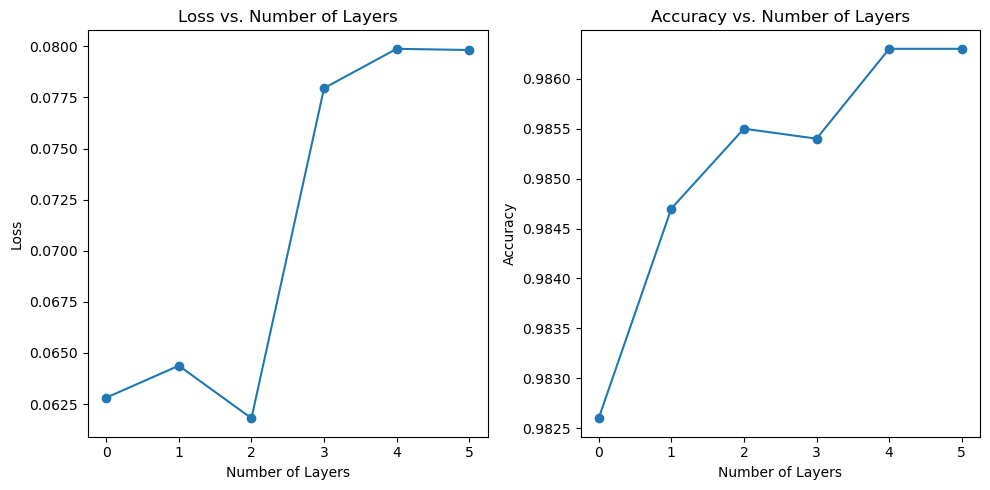

In [80]:
import matplotlib.pyplot as plt

def plot_metrics(training_performance):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Assuming your dictionary structure is {layer_number: [loss, accuracy]}
    layers = list(training_performance.keys())
    losses = [training_performance[key][0] for key in layers]
    accuracies = [training_performance[key][1] for key in layers]

    axes[0].plot(layers, losses, marker='o')
    axes[0].set_xlabel('Number of Layers')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss vs. Number of Layers')

    axes[1].plot(layers, accuracies, marker='o')
    axes[1].set_xlabel('Number of Layers')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy vs. Number of Layers')

    plt.tight_layout()
    plt.show()

plot_metrics(training_performance)

For a comparison, I am going to train a model with the same architecture, but not using complexity scheduling.

In [84]:
model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    Dense(350, activation='relu'),
    Dropout(0.5),
    Dense(175, activation='relu'),
    BatchNormalization(),
    Dense(116, activation='relu'),
    BatchNormalization(),
    Dense(87, activation='relu'),
    BatchNormalization(),
    Dense(70, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 784)               0         
                                                                 
 dense_173 (Dense)           (None, 350)               274750    
                                                                 
 dropout_47 (Dropout)        (None, 350)               0         
                                                                 
 dense_174 (Dense)           (None, 175)               61425     
                                                                 
 batch_normalization_33 (Bat  (None, 175)              700       
 chNormalization)                                                
                                                                 
 dense_175 (Dense)           (None, 116)               20416     
                                                      

In [85]:
history = model.fit(x_train, y_train, 
                    epochs=100000, 
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)],
                   verbose=0)

In [86]:
print(model.evaluate(x_test, y_test, verbose=0))

[0.05344443395733833, 0.9850000143051147]


The complexity scheduling model outperformed the same model architecture trained normally 0.986299991607666 to 0.9850000143051147 albeit much slower to train. However, by no means does this notebook attempt to maximize performance of this architecture.

The main point of this being an initial experimentation with adjusting the complexity of components of the model, whether data or architecture during training. For my next project in this domain, I will experiment with training a model on different subsections of a dataset that contain different properties by virture of supervised learning.